# 랜덤포레스트 실습
- 건강 이상여부 예측 모델

In [1]:
import pandas as pd
import numpy as np

np.random.seed(44)
n = 1000

df = pd.DataFrame({
    '성별': np.random.choice(['남', '여'], size=n),
    '나이': np.random.randint(20, 66, size=n),
    '키': np.random.normal(165, 8, size=n).round(1),
    '체중': np.random.normal(65, 12, size=n).round(1),
    '수축기혈압': np.random.normal(125, 15, size=n).round(0),
    '이완기혈압': np.random.normal(80, 10, size=n).round(0),
    '운동횟수': np.random.randint(0, 8, size=n),
    '흡연여부': np.random.choice(['예', '아니오'], size=n, p=[0.3, 0.7]),
    '음주빈도': np.random.poisson(1.5, size=n),
})

**- 키, 체중 변수를 모두 사용하지 않고, BMI라는 새로운 변수 제작**

In [3]:
df['BMI']=df['체중']/((df['키']/100)*(df['키'])/100)

**- 이상자 여부 : 수축기 > 140 또는 이완기 > 90 → 1**

In [2]:
df['이상자'] = ((df['수축기혈압'] > 140) | (df['이완기혈압'] > 90)).astype(int)

**- 범주형 변수 인코딩**

In [4]:
df['성별코드'] = df['성별'].map({'남':0, '여':1})
df['흡연코드'] = df['흡연여부'].map({'아니오':0, '예':1})

### 모델 제작

**1. 변수 생성**

In [6]:
X = df[['성별코드', '나이', 'BMI', '운동횟수', '흡연코드', '음주빈도']]
y = df['이상자']

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**2. 모델 학습**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42, class_weight='balanced')
rf.fit(x_train, y_train)

**3. 예측**

In [8]:
y_pred=rf.predict(x_test)
y_proba=rf.predict_proba(x_test)[:,1]

**4. 평가**

In [12]:
def evaluate(df):
    print('오차행렬 : \n', confusion_matrix(y_test, y_pred))
    print('정밀도 :', precision_score(y_test, y_pred))
    print('재현율 :', recall_score(y_test, y_pred))
    print('f1 score :', f1_score(y_test, y_pred))
    print('AUC :', roc_auc_score(y_test, y_proba))
evaluate(df)

오차행렬 : 
 [[126  17]
 [ 54   3]]
정밀도 : 0.15
재현율 : 0.05263157894736842
f1 score : 0.07792207792207792
AUC : 0.5044779781621886


**5. 정밀도 vs 재현율 트레이드 오프 시각화**

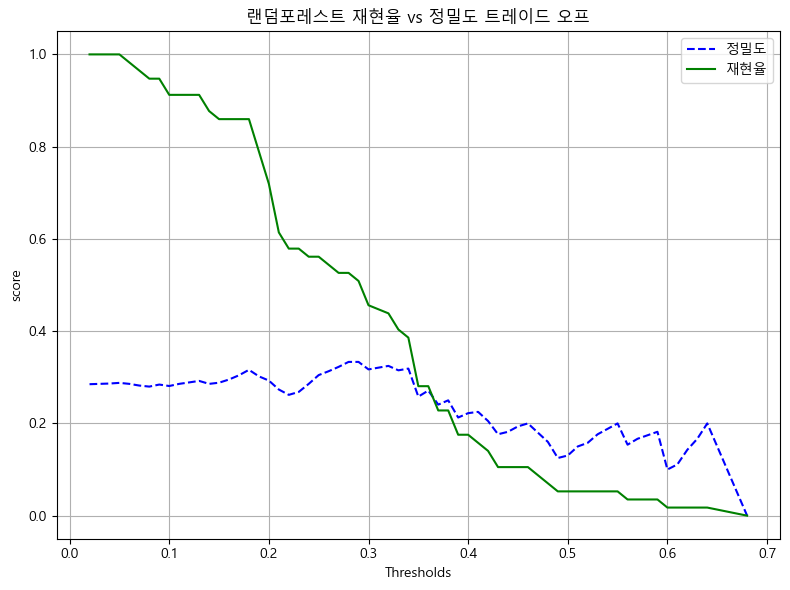

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def tradeoff_visual(name, model, X_te):
    y_scores=model.predict_proba(X_te)[:,1]

    precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

    matplotlib.rc('font', family='Malgun Gothic')
    plt.figure(figsize=(8,6))
    plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율')
    plt.xlabel('Thresholds')
    plt.ylabel('score')
    plt.title(f'{name} 재현율 vs 정밀도 트레이드 오프')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
tradeoff_visual('랜덤포레스트', rf, x_test)

**6. 변수 중요도 시각화**

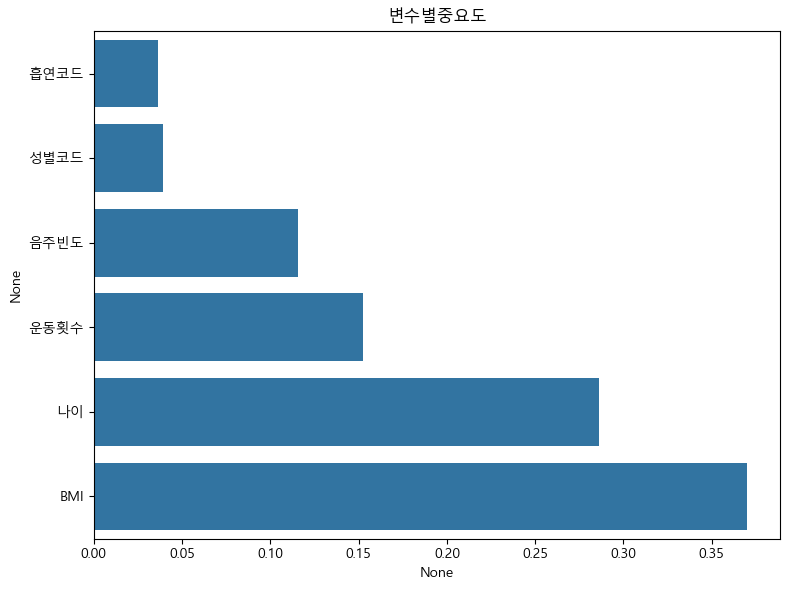

In [11]:
feature_names = df[['성별코드', '나이', 'BMI', '운동횟수', '흡연코드', '음주빈도']].columns
importance=pd.Series(rf.feature_importances_, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x=importance, y=importance.index)
plt.title('변수별중요도')
plt.tight_layout()
plt.show()
